In [29]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats



Análisis Exploratorio de Datos (EDA)
i. Tipo de dato
Primero, verificamos los tipos de datos y su clasificación en el DataFrame:

In [30]:
data = pd.read_csv("./Barcelona_rent_price.csv", delimiter=';')

In [31]:
data.info()  #complementar con informacion ya explorada

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                2311 non-null   int64  
 1   Trimester           2311 non-null   int64  
 2   District            2311 non-null   object 
 3   Neighbourhood       2311 non-null   object 
 4   Price (euro/month)  2311 non-null   float64
 5   Price (euro/m2)     2311 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 108.5+ KB


ii. Estadística descriptiva
Calculamos las estadísticas descriptivas para resumir la tendencia central, dispersión y forma de la distribución de los datos:

In [32]:
data.describe()  #complementar con informacion ya explorada

,Year,Trimester,Price (euro/month),Price (euro/m2)
count,2311.000000,2311.000000,2311.000000,2311.000000
mean,2017.745565,2.440502,820.780658,12.134531
std,2.463095,1.116498,255.450568,2.419414
min,2014.000000,1.000000,142.340000,3.180000
25%,2016.000000,1.000000,653.860000,10.500000
50%,2018.000000,2.000000,777.210000,12.100000
75%,2020.000000,3.000000,926.500000,13.750000
max,2022.000000,4.000000,2034.000000,21.300000


iii. Función de distribución
Visualizamos la distribución de la variable objetivo "Price (euro/m2)" utilizando un histograma:

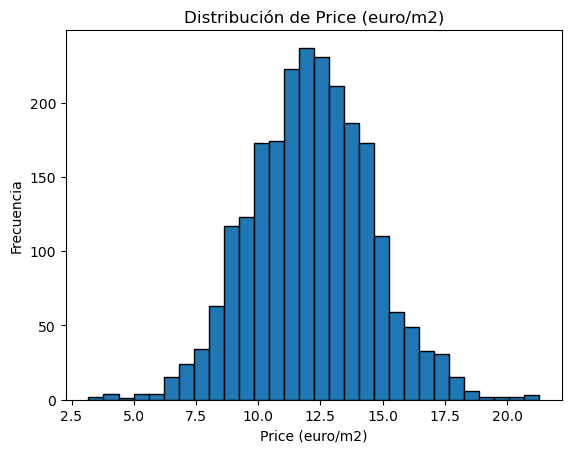

In [33]:
plt.hist(data['Price (euro/m2)'], bins=30, edgecolor='k')
plt.title('Distribución de Price (euro/m2)')
plt.xlabel('Price (euro/m2)')
plt.ylabel('Frecuencia')
plt.show()

iv. Interpretar la variable objetivo en base a la función de distribución
Creamos un boxplot para identificar visualmente la presencia de outliers en "Price (euro/m2)":

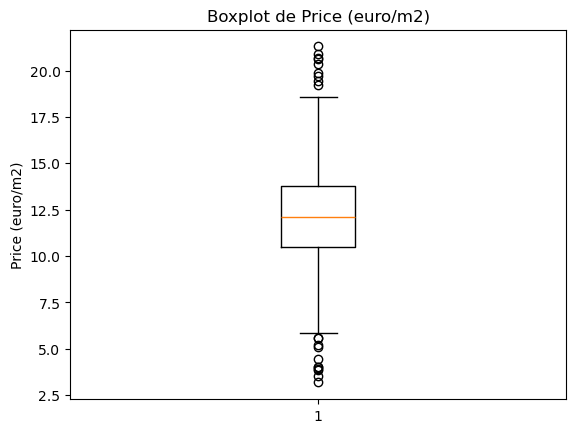

In [34]:
plt.boxplot(data['Price (euro/m2)'])
plt.title('Boxplot de Price (euro/m2)')
plt.ylabel('Price (euro/m2)')
plt.show()

Corrección o imputación de outliers
Detección de los outliers con kmeans

In [35]:
# Selección de columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

In [36]:
# Escalar los datos
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(numeric_data)

calculo de tamaño de clusters

In [37]:
# Calcular SSE para diferentes valores de k
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse[k] = kmeans.inertia_  # SSE para el número de clústeres k

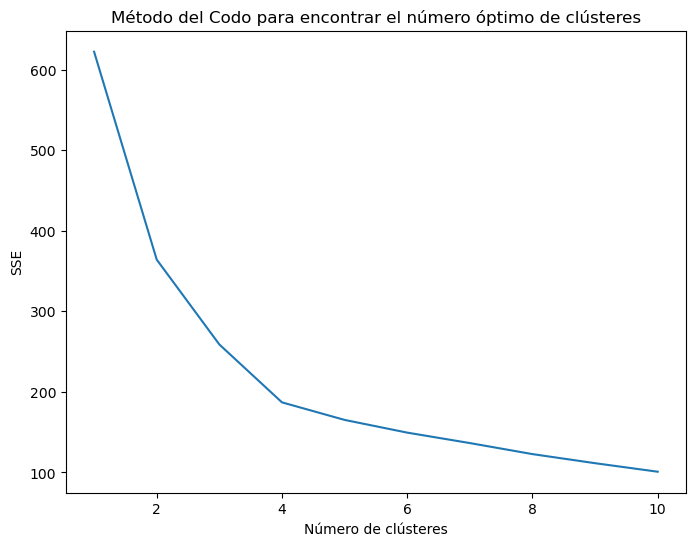

In [38]:

# Graficar SSE vs. k
plt.figure(figsize=(8, 6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Número de clústeres")
plt.ylabel("SSE")
plt.title("Método del Codo para encontrar el número óptimo de clústeres")
plt.show()

Se confirma que el numero adecuado de clusters es 4 

In [39]:
# teniendo en cuenta el grafico del codo , encontramos que el tamaño de cluster mas adecuado es 4
# Aplicar K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

In [40]:
# Añadir los clusters al dataframe original
data['Cluster'] = clusters

In [41]:

# Calcular la distancia de cada punto al centroide del clúster
data['Distance_to_Centroid'] = np.linalg.norm(data_scaled - kmeans.cluster_centers_[clusters], axis=1)

In [42]:
# Definir umbral para considerar un punto como outlier con hasta un 5% de eliminacion de registros debido a que contamos con datos limitados
threshold = data['Distance_to_Centroid'].quantile(0.95)

In [43]:
# Identificar outliers
data['Is_Outlier'] = data['Distance_to_Centroid'] > threshold
# Contar el número de outliers identificados
num_outliers = data['Is_Outlier'].sum()
# Contar el número total de registros en el dataset original
total_records = len(data)
# Calcular el porcentaje de outliers
percentage_outliers = (num_outliers / total_records) * 100
# Mostrar los resultados
print(f'Número de outliers: {num_outliers}')
print(f'Número total de registros: {total_records}')
print(f'Porcentaje de outliers: {percentage_outliers:.2f}%')

Número de outliers: 116
Número total de registros: 2311
Porcentaje de outliers: 5.02%


In [44]:
# Visualización de outliers
outliers = data[data['Is_Outlier']]


In [45]:
outliers_info = outliers[['Year', 'Trimester', 'District', 'Neighbourhood', 'Price (euro/m2)', 'Cluster', 'Distance_to_Centroid']]
print(outliers_info.head())

     Year  Trimester             District    Neighbourhood  Price (euro/m2)  \
44   2014          1           Nou Barris      Can Peguera             6.03   
87   2014          2            Les Corts        Pedralbes            12.52   
90   2014          2  Sarria-Sant Gervasi  les Tres Torres            14.40   
122  2014          2          Sant Andreu    Baro de Viver             4.03   
157  2014          3            Les Corts        Pedralbes            12.06   

     Cluster  Distance_to_Centroid  
44         2              0.447767  
87         2              0.492854  
90         2              0.472023  
122        2              0.522009  
157        1              0.481651  


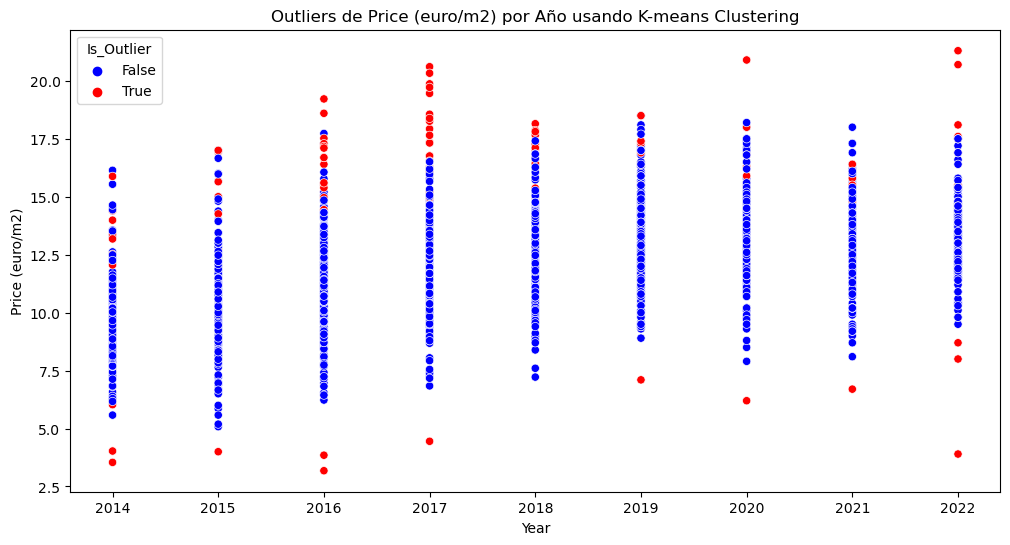

In [46]:
# Visualizar los outliers por año
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='Year', y='Price (euro/m2)', hue='Is_Outlier', palette={True: 'red', False: 'blue'})
plt.title('Outliers de Price (euro/m2) por Año usando K-means Clustering')
plt.show()

In [47]:
# Eliminar outliers antes de continuar con el modelado
data_clean = data[~data['Is_Outlier']]

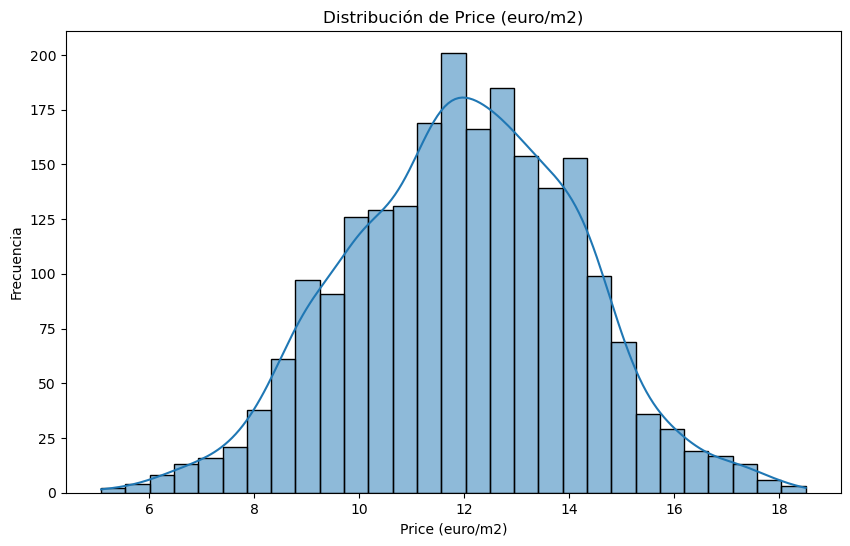

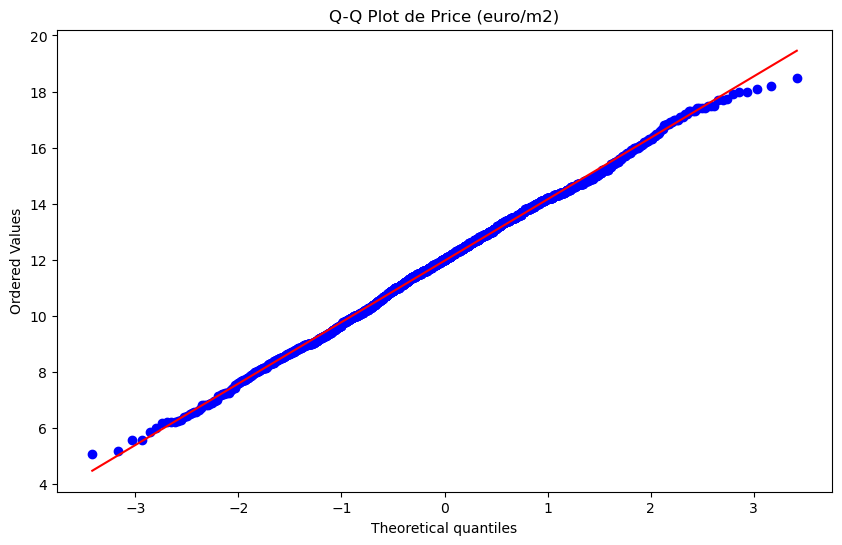

Prueba de Shapiro-Wilk
Estadístico=0.998, p=0.016
Distribución probablemente no normal
Prueba de Kolmogorov-Smirnov
Estadístico=0.019, p=0.374
Distribución probablemente normal


In [48]:
# Histograma y KDE Plot para 'Price (euro/m2)'
plt.figure(figsize=(10, 6))
sns.histplot(data_clean['Price (euro/m2)'], kde=True)
plt.title('Distribución de Price (euro/m2)')
plt.xlabel('Price (euro/m2)')
plt.ylabel('Frecuencia')
plt.show()

# Q-Q Plot para 'Price (euro/m2)'
plt.figure(figsize=(10, 6))
stats.probplot(data_clean['Price (euro/m2)'], dist="norm", plot=plt)
plt.title('Q-Q Plot de Price (euro/m2)')
plt.show()

# Prueba de Shapiro-Wilk para 'Price (euro/m2)'
stat, p = stats.shapiro(data_clean['Price (euro/m2)'])
print('Prueba de Shapiro-Wilk')
print('Estadístico=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Distribución probablemente normal')
else:
    print('Distribución probablemente no normal')

# Prueba de Kolmogorov-Smirnov para 'Price (euro/m2)'
d, p_value = stats.kstest(data_clean['Price (euro/m2)'], 'norm', args=(data_clean['Price (euro/m2)'].mean(), data_clean['Price (euro/m2)'].std()))
print('Prueba de Kolmogorov-Smirnov')
print('Estadístico=%.3f, p=%.3f' % (d, p_value))
if p_value > 0.05:
    print('Distribución probablemente normal')
else:
    print('Distribución probablemente no normal')


EVALUANDO EL MODELO CON ELIMINACION DE OUTLIERS CON KMEANS, SE CONFIRMA POR KOLMOGOROV QUE LA DISTRIBUCION DE LOS DATOS ES NORMAL.

In [49]:
# Binarización de variables categóricas
data_encoded = pd.get_dummies(data_clean, columns=['District', 'Neighbourhood'])

In [50]:
# División Train Test
X = data_encoded.drop('Price (euro/m2)', axis=1)
y = data_encoded['Price (euro/m2)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [51]:
# Transformación (Escalado), previo al procesamiento debemos escalar los datos para llevarlos a una escala comun
# Mejora del Rendimiento del Modelo,Convergencia Más Rápida,Equidad de las Características.
#Metodos comunes de escalado: Min-max scaling(normalizacion) , standard scaling(estandarizacion), robust scaling
# en nuestro caso seleccionaremos  MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
from sklearn.linear_model import Ridge

# Definir el modelo de regresión Ridge
ridge_model = Ridge()
# Entrenar y evaluar el modelo Ridge
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [53]:
# Entrenar y evaluar el modelo Ridge
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'MAE (Ridge): {mae_ridge}, MSE (Ridge): {mse_ridge}, RMSE (Ridge): {rmse_ridge}, R² (Ridge): {r2_ridge}')

MAE (Ridge): 0.4916088822009097, MSE (Ridge): 0.4607188546634674, RMSE (Ridge): 0.6787627381224366, R² (Ridge): 0.9117413927163492


El ajuste del modelo mejora considerablemente, pasamos de un 0.84 al 0.91 utilizando kmeans para gestion de outliers

In [54]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
# Validación cruzada con KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(ridge_model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)

print(f'Validación cruzada R²: {scores.mean()}, {scores.std()}')

Validación cruzada R²: 0.9067083608920731, 0.015200429004266078


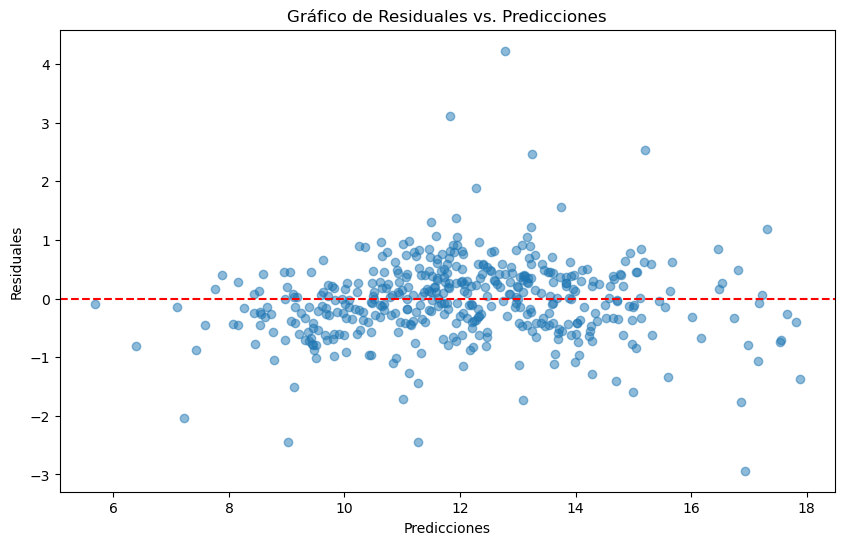

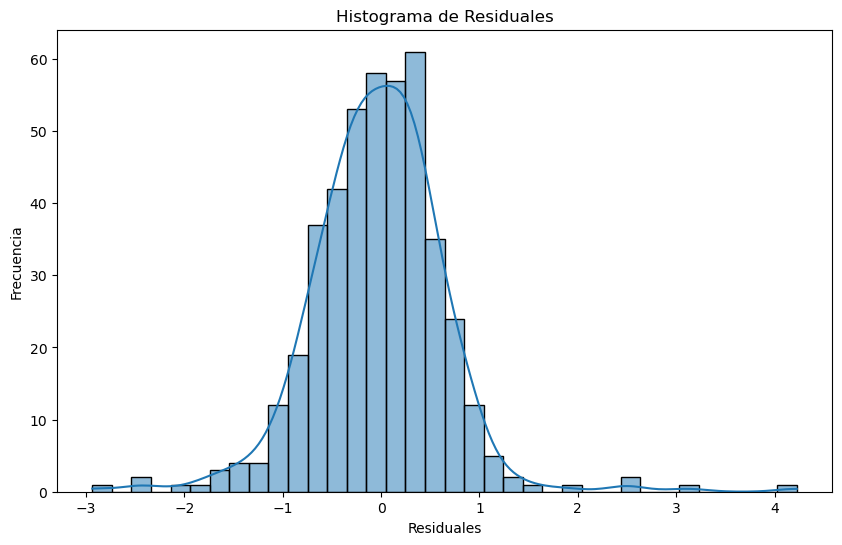

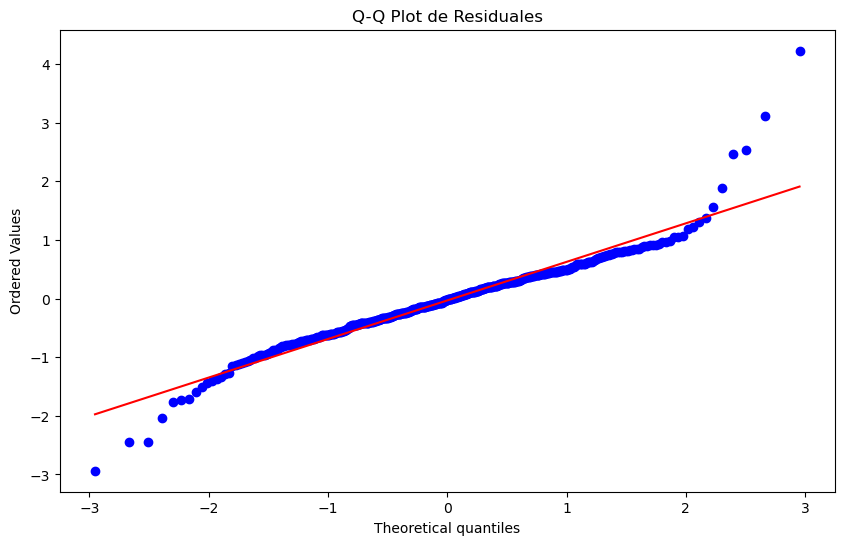

In [55]:
# Calcular residuales
residuals = y_test - y_pred_ridge
# Gráfico de Residuales vs. Predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ridge, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de Residuales vs. Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.show()

# Histograma de Residuales
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histograma de Residuales')
plt.xlabel('Residuales')
plt.ylabel('Frecuencia')
plt.show()

# Q-Q Plot de Residuales
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot de Residuales')
plt.show()
#Este código te ayudará a verificar si hay patrones no deseados en los errores de predicción y te dará una mejor idea de cómo está funcionando tu modelo.




### Análisis de Residuales

1. **Gráfico de Residuales vs. Predicciones:**
   - Los residuales están distribuidos aleatoriamente alrededor del eje horizontal (en 0), indicando que no hay patrones claros en los errores y que el modelo está capturando bien la variabilidad de los datos.

2. **Histograma de Residuales:**
   - El histograma muestra una distribución aproximadamente normal de los residuales, lo que sugiere que los errores del modelo están distribuidos normalmente.

3. **Q-Q Plot de Residuales:**
   - El Q-Q Plot indica que la mayoría de los puntos siguen la línea roja, sugiriendo que los residuales están normalmente distribuidos. Aunque hay algunos valores en los extremos que se desvían, esto es común en conjuntos de datos reales.

### Conclusión
Los análisis de los residuales sugieren que el modelo de regresión Ridge está capturando bien la estructura de los datos y que las suposiciones de normalidad de los errores se mantienen razonablemente bien. Esto refuerza la validez del modelo para hacer inferencias y predicciones basadas en los datos disponibles.


In [56]:
#prediccion con nuevos datos
# Preprocesamiento de los nuevos datos
# Cargar los nuevos datos
new_data = pd.DataFrame({
    'Year': [2024, 2026, 2027, 2028],
    'Trimester': [1, 2, 3, 4],
    'District': ['Eixample', 'Sant Martí', 'Gràcia', 'Ciutat Vella'],
    'Neighbourhood': ['Dreta de l\'Eixample', 'El Poblenou', 'Vila de Gràcia', 'El Raval']
})
new_data_encoded = pd.get_dummies(new_data, columns=['District', 'Neighbourhood'])
missing_cols = set(X.columns) - set(new_data_encoded.columns)
for c in missing_cols:
    new_data_encoded[c] = 0
new_data_encoded = new_data_encoded[X.columns]
new_data_scaled = scaler.transform(new_data_encoded)

# Realizar la predicción
predictions = ridge_model.predict(new_data_scaled)
new_data['Predicted Price (euro/m2)'] = predictions

# Mostrar las predicciones
print(new_data[['Year', 'Trimester', 'District', 'Neighbourhood', 'Predicted Price (euro/m2)']])

   Year  Trimester      District        Neighbourhood  \
0  2024          1      Eixample  Dreta de l'Eixample   
1  2026          2    Sant Martí          El Poblenou   
2  2027          3        Gràcia       Vila de Gràcia   
3  2028          4  Ciutat Vella             El Raval   

   Predicted Price (euro/m2)  
0                   6.428670  
1                   7.136369  
2                   7.374179  
3                   9.184370  


El precio/m2 , predicho es "relativamente real" pero se aleja de los valores medios para años anteriores proximos a el 
se sospecha que algo no va bien con la prediccion
los datos estan desviando las predicciones 


como conclusiones, 
1. nuestra distribucion de datos se aproxima a una distribucion normal, sin tener certeza total
2. las pruebas de normalidad para los dos elecciones de gestion de outliers, reemplazo por mediana y la segunda, eliminacion por kmeans , encontramos que los kmeans se asemejan mas a una distribucion normal
3. eleccion de modelo de entrenamiento , al tener datos posiblemente no normales , se evaluaron diferentes modelos con mejores resultados para random forest , el otro evaluado fue regresion ridge 
3. evaluando de las dos modelos  con transformacion box cox , o simplemente con el resultado de kmeans , obtenemos predicciones similares para simplificar , eligiremos, no transformar datos POR EL MOMENTO.

Confirmamos que nuestro modelo ridge ajusta bien, y la validación cruzada es correcta, pero los resultados siguien siendo poco sensibles al paso del tiempo.

Se realizan pruebas , con diferentes reemplazos de outliers (media,mediana, moda) , con modelos huber regressor y random forest, ambos modelos ajustados aprox 85% , y validacion cruzada tambien con un buen ajuste <90%
pero las predicciones siguen sin satisfasernos.
poca sensibilidad al paso de los años.

resumen nuevas pruebas: 
Prueba de Shapiro-Wilk:
Estadístico= 0.998, p= 0.030
Distribución probablemente no normal
Prueba de Kolmogorov-Smirnov:
Estadístico= 0.018, p= 0.483
Distribución probablemente normal

Model: Ridge
MAE: 0.4863546609415616, MSE: 0.45247174315563066, RMSE: 0.6726601988787732, R²: 0.9133212685309093
Cross-Validation R²: 0.90351933190192, 0.012487583899703843

Model: Lasso
MAE: 1.8306683393229557, MSE: 5.223743848895104, RMSE: 2.285551103978011, R²: -0.0006978274131781426
Cross-Validation R²: -0.0015905273424927646, 0.0016290731300665426

Model: ElasticNet
MAE: 1.8306683393229557, MSE: 5.223743848895104, RMSE: 2.285551103978011, R²: -0.0006978274131781426
Cross-Validation R²: -0.0015905273424927646, 0.0016290731300665426

Model: RandomForest
MAE: 0.43422918036565, MSE: 0.4279994096296083, RMSE: 0.654216638147952, R²: 0.9180093642146977
Cross-Validation R²: 0.9106520560921867, 0.014756940659586208
   Year  Trimester      District        Neighbourhood  \
0  2024          1      Eixample  Dreta de l'Eixample   
1  2024          2    Sant Martí          El Poblenou   
...
0                  10.040127  
1                  10.049910  
2                  10.067333  
3                  10.164931  

Ajustó mejor el modelo de random forest, pero las predicciones siguen sin acercarse a la media ,
Posteriormente se realizan pruebas con series temporales, usando Prophet , con resultados similares, buenos ajustes, pero predicciones poco sensibles al paso del tiempo.
hay una aplanamiento en las predicciones, y no un crecimiento constante significativo de las predicciones.
SE PROCEDE A FEATURE ENGINEERING ----->recon_feat_enginerring.ipynb